In [1]:
import photutils
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import glob
from astropy.io import fits


from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from scipy.stats import sigmaclip


In [2]:
photutils.__version__

'1.6.0'

In [46]:
data_dir = '/grp/hst/wfc3v/wfc3photom/data/uvis_scan_monitor/data/GD153/F606W/'
flts = sorted(glob.glob(data_dir+'*flt.fits'))
fcrs = sorted(glob.glob(data_dir+'*fcr.fits'))

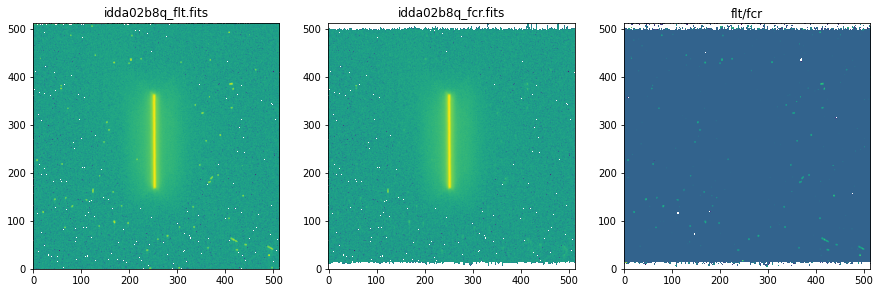

In [47]:
order = 2

fig, ax = plt.subplots(1,3,figsize=(15,5))
with fits.open(flts[order]) as f:
    flt_data = f[1].data
with fits.open(fcrs[order]) as f:
    fcr_data = f[0].data

flt_plot = ax[0].imshow(flt_data, norm=LogNorm(), origin='lower')
ax[0].set_title(flts[order].split('/')[-1])
fcr_plot = ax[1].imshow(fcr_data, norm=LogNorm(), origin='lower')
ax[1].set_title(fcrs[order].split('/')[-1])
div_plot = ax[2].imshow(flt_data/fcr_data, norm=LogNorm(), origin='lower')
ax[2].set_title('flt/fcr')
    
plt.show()

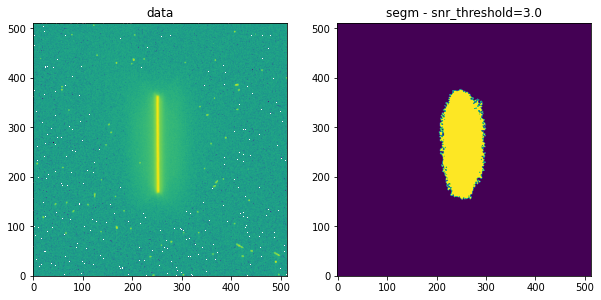

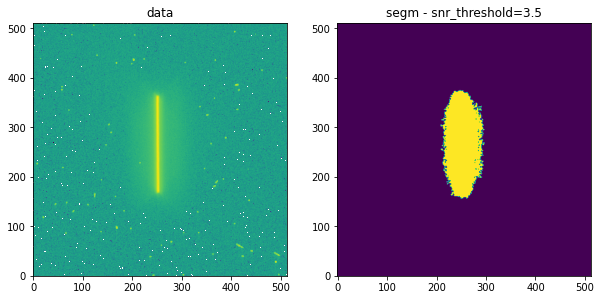

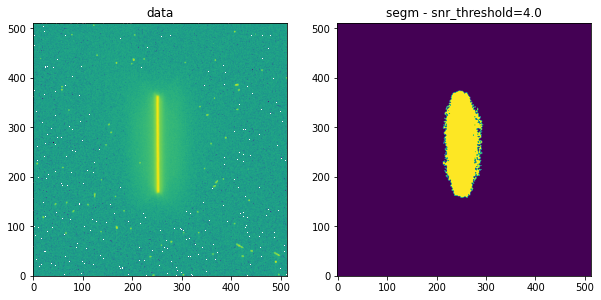

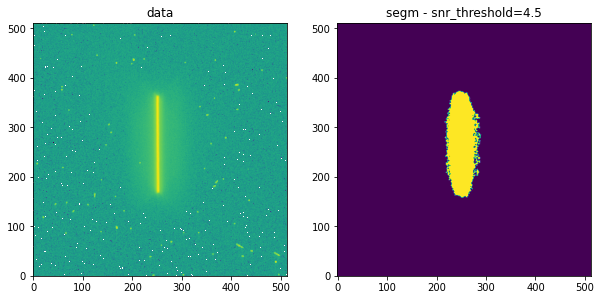

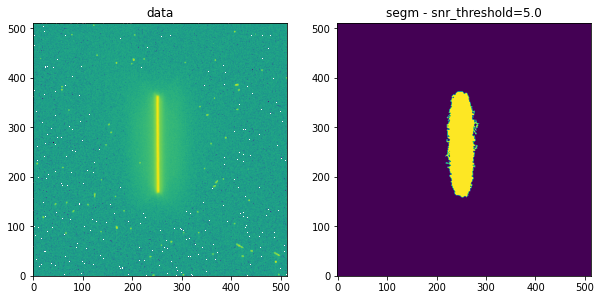

/var/folders/_x/2y1l1lzd43j43bgjx2t8ldjc0002s2/T/ipykernel_52752/546854251.py:34: RuntimeWarning: invalid value encountered in true_divide
  diff = snr_threshold_segms[i+1]._data / segm._data


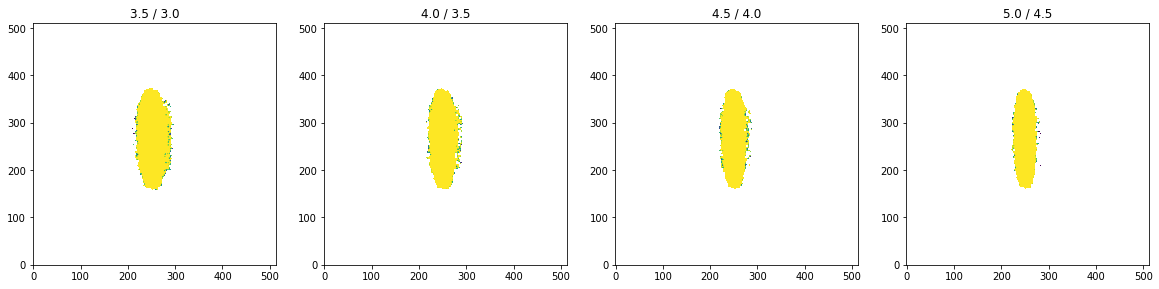

/var/folders/_x/2y1l1lzd43j43bgjx2t8ldjc0002s2/T/ipykernel_52752/546854251.py:40: RuntimeWarning: invalid value encountered in true_divide
  ax.imshow(snr_threshold_segms[-1]._data / snr_threshold_segms[0]._data, origin='lower')


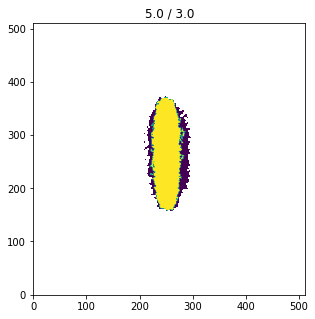

In [48]:
with fits.open(flts[order]) as f:
    data = f[1].data
    sigma_kernel = 3
    size_kernel = (3,3)
    n_pixels = 500
    
    snr_threshold_segms = []
    snr_thresholds = [3.0, 3.5, 4.0, 4.5, 5.0]
    
    for snr_threshold in snr_thresholds:
        threshold = photutils.detect_threshold(data, nsigma=snr_threshold)
        
        # construct gaussian kernel to smooth image
        sigma = sigma_kernel * gaussian_fwhm_to_sigma
        kernel = Gaussian2DKernel(sigma, x_size=size_kernel[0],
                                  y_size=size_kernel[1])
        kernel.normalize()

        # pass in data, convolution kernel to make segmentation map

        segm = photutils.detect_sources(data, threshold, npixels=n_pixels,
                              filter_kernel=kernel)
        snr_threshold_segms.append(segm)
        
        fig, ax = plt.subplots(1,2,figsize=(10,5))
        ax[0].imshow(data, origin='lower', norm=LogNorm())
        ax[1].imshow(segm, origin='lower')
        ax[0].set_title('data')
        ax[1].set_title(f'segm - snr_threshold={snr_threshold}')
        plt.show()

        
fig,  ax = plt.subplots(1,4,figsize=(20,5))
for i, segm in enumerate(snr_threshold_segms[:-1]):
    diff = snr_threshold_segms[i+1]._data / segm._data
    ax[i].imshow(diff, origin='lower')
    ax[i].set_title(f'{snr_thresholds[i+1]} / {snr_thresholds[i]}')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(snr_threshold_segms[-1]._data / snr_threshold_segms[0]._data, origin='lower')
ax.set_title(f'{snr_thresholds[-1]} / {snr_thresholds[0]}')
plt.show()

In [42]:
props = photutils.source_properties(data, segm)
props.to_table()

        Use `~photutils.segmentation.SourceCatalog` instead. [warnings]


id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini
,pix,pix,,,,,,,,pix,pix,pix,pix,,,pix,pix,pix,pix,pix2,pix,pix,pix,pix,deg,,,,pix2,pix2,pix2,1 / pix2,1 / pix2,1 / pix2,
int64,float64,float64,object,object,float64,object,object,object,object,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,251.49993885362667,265.4958560300921,None,None,6761920.0,None,None,None,None,217.0,290.0,158.0,372.0,6.497786,12214.037,276.0,278.0,252.0,243.0,11016.0,59.21572178231587,1142.2062402294093,55.28340422685134,4.205342819556885,-89.63782606399045,0.9971025704585739,0.9239311891449272,13.145992276719195,17.80631770035046,-19.206676413483326,3056.133373439093,0.05654314187426065,0.0007107057819001559,0.0003294441128582307,0.8585050598285244


In [43]:
props = photutils.segmentation.SourceCatalog(data, segm)
props.to_table()

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float32,float32,float64,float32,float64,float64,float64
1,251.49993885362667,265.4958560300921,None,217,290,158,372,11016.0,55.28340422685134,4.205342819556885,-89.63782606399045,0.9971025704585739,6.497786,12214.037,0.0,6761920.0,nan,6541817.804297822,nan


In [ ]:
def detect_sources_scan(data, snr_threshold=3.0, sigma_kernel=3,
                        size_kernel=(3, 3), n_pixels=500, show=False):

    threshold = detect_threshold(data, nsigma=snr_threshold)

    # construct gaussian kernel to smooth image
    sigma = sigma_kernel * gaussian_fwhm_to_sigma
    kernel = Gaussian2DKernel(sigma, x_size=size_kernel[0],
                              y_size=size_kernel[1])
    kernel.normalize()

    # pass in data, convolution kernel to make segmentation map

    segm = detect_sources(data, threshold, npixels=n_pixels,
                          filter_kernel=kernel)

    props = source_properties(data, segm)
    properties_tbl = props.to_table()
